In [49]:
import numpy as np
import pandas as pd
import yfinance as yf
import arch
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import quantstats as qs

from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [50]:
universe = {"VNQ": 'Vanguard Real Estate Index Fund',
"XLK": 'Technology Select Sector SPDR Fund',
"XLE": 'Energy Select Sector SPDR Fund',
"XLV": 'Health Care Select Sector SPDR Fund',
"XLF": 'Financial Select Sector SPDR Fund',
"XLI": 'Industrials Select Sector SPDR Fund',
"XLB": 'Materials Select Sector SPDR Fund',
"XLY": 'Consumer Discretionary Select Sector SPDR Fund',
"XLP": 'Consumer Staples Select Sector SPDR Fund',
"XLU": 'Utilities Select Sector SPDR Fund',
           }
symbols = universe.keys()
tickers = [yf.Ticker(symbol) for symbol in symbols]

In [51]:
special_exchanges = {}

In [52]:
exchanges = {}
for symbol in symbols:
    exchanges[symbol] = 'SMART' if not symbol in special_exchanges else special_exchanges[symbol]

In [53]:
def get_data(ticker):
    data = ticker.history(period='max')
    return data['Close'].rename(ticker.ticker)

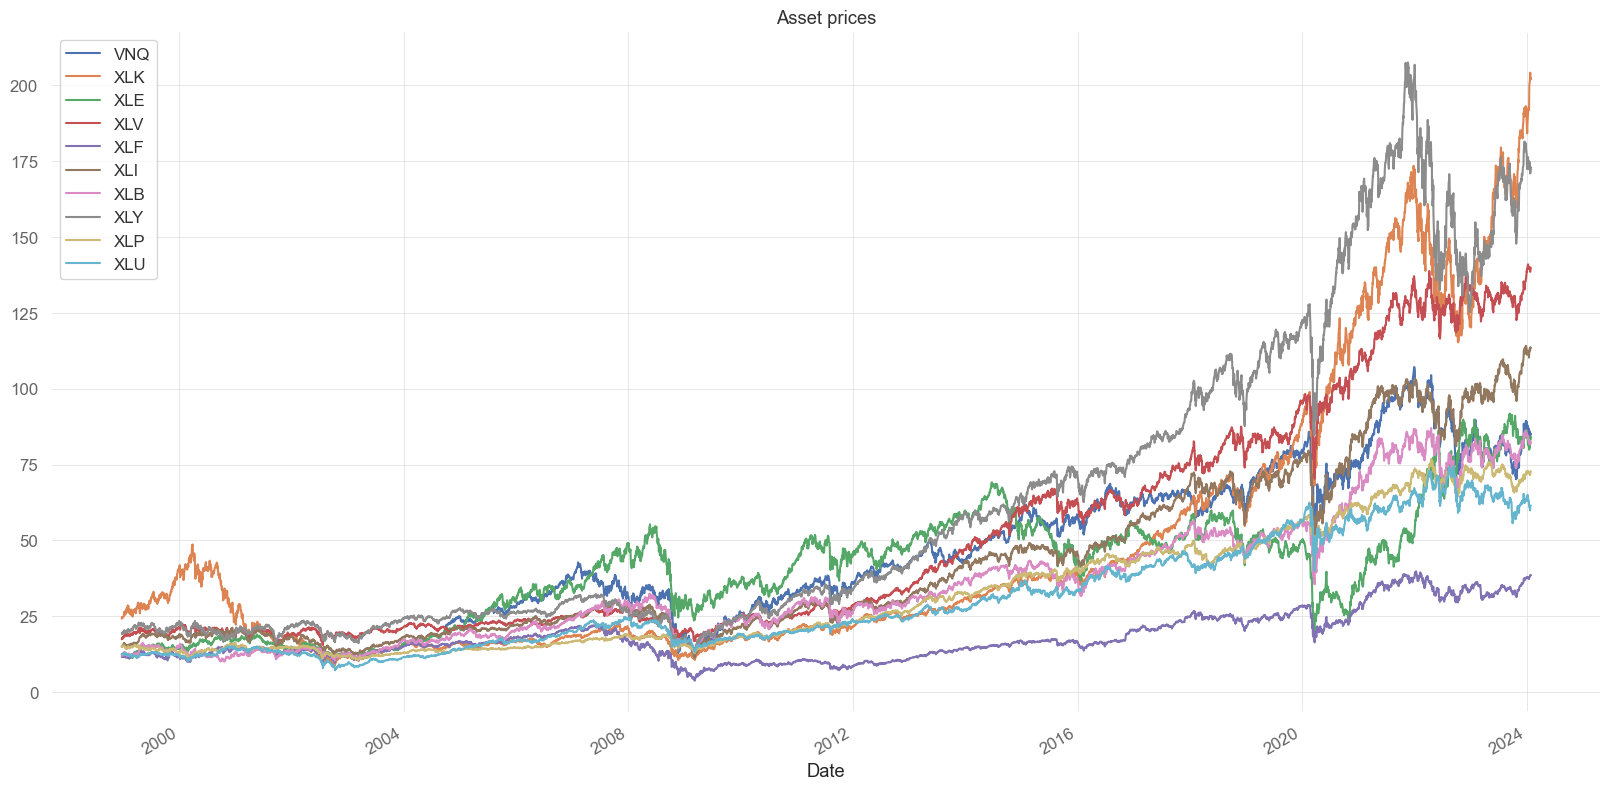

In [54]:
full_df = pd.DataFrame({symbol.ticker: get_data(symbol) for symbol in tickers})
full_df.plot(figsize=(20,10), grid=True, title='Asset prices');
full_df.index = full_df.index.tz_localize(None)

In [55]:
[print(col, full_df[col].first_valid_index()) for col in full_df.columns]

VNQ 2004-09-29 00:00:00
XLK 1998-12-22 00:00:00
XLE 1998-12-22 00:00:00
XLV 1998-12-22 00:00:00
XLF 1998-12-22 00:00:00
XLI 1998-12-22 00:00:00
XLB 1998-12-22 00:00:00
XLY 1998-12-22 00:00:00
XLP 1998-12-22 00:00:00
XLU 1998-12-22 00:00:00


[None, None, None, None, None, None, None, None, None, None]

<Axes: >

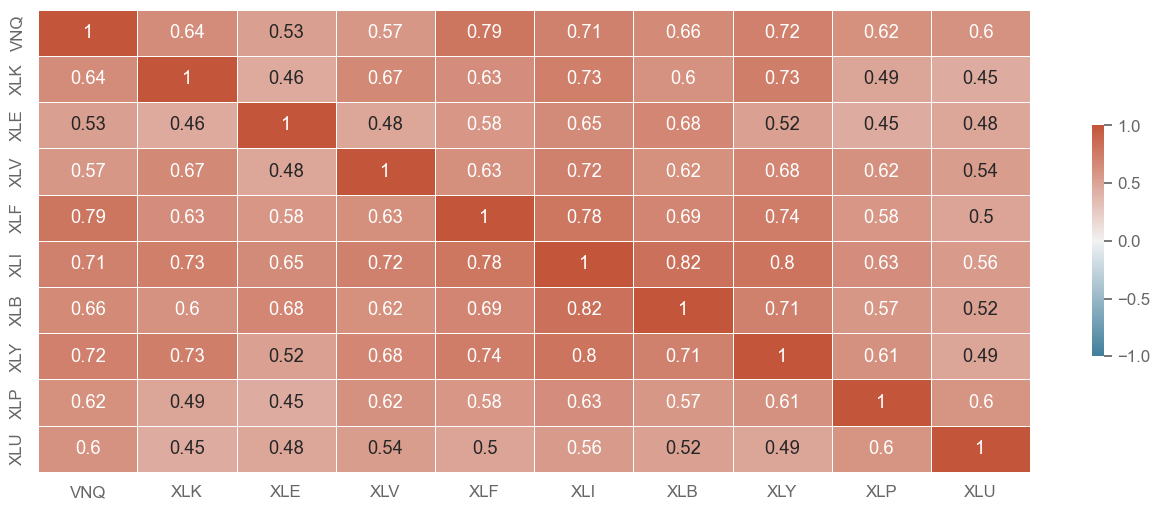

In [56]:
import seaborn as sns
corr = full_df.pct_change().corr()
f, ax = plt.subplots(figsize=(16, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=1,vmin=-1, center=0,
            linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

In [57]:
def ewmac_forecast_scalar(Lfast, Lslow):
    fsdict=dict(l2_8=10.6, l4_16=7.5, l8_32=5.3, l16_64=3.75, l32_128=2.65, l64_256=1.87)
    
    lkey="l%d_%d" % (Lfast, Lslow)
    
    if lkey in fsdict:
        return fsdict[lkey]
    else:
        print ("Warning: No scalar defined for Lfast=%d, Lslow=%d, using default of 1.0" % (Lfast, Lslow))
        return 1.0
   
def ewmac(price, Lfast=16):
    vol_lookback = 25
    
    Lslow=4*Lfast
    
    fast_ewma=price.ewm(span=Lfast).mean()
    slow_ewma=price.ewm(span=Lslow).mean()
    raw_ewmac=fast_ewma - slow_ewma
    
    stdev_returns=price.diff().ewm(span=vol_lookback).std()
    vol_adj_ewmac=raw_ewmac/stdev_returns
    
    f_scalar=ewmac_forecast_scalar(Lfast, Lslow)

    forecast=vol_adj_ewmac*f_scalar
    
    return (np.maximum(np.minimum(forecast, 20), -20))/20

In [58]:
ewmacs = pd.DataFrame(index = full_df.index)
avg_ewmacs = pd.DataFrame(index = full_df.index)
lengths = [16, 32, 64]
for symbol in symbols:
    for Lfast in lengths:
        ewmacs[f'{symbol}_{Lfast}'] = ewmac(full_df[symbol], Lfast)
        if not symbol in avg_ewmacs.columns:
            avg_ewmacs[symbol] = ewmac(full_df[symbol], Lfast)
        else:
            avg_ewmacs[symbol] += ewmac(full_df[symbol], Lfast)
    avg_ewmacs[symbol] /= len(lengths)
avg_ewmacs = avg_ewmacs.shift()

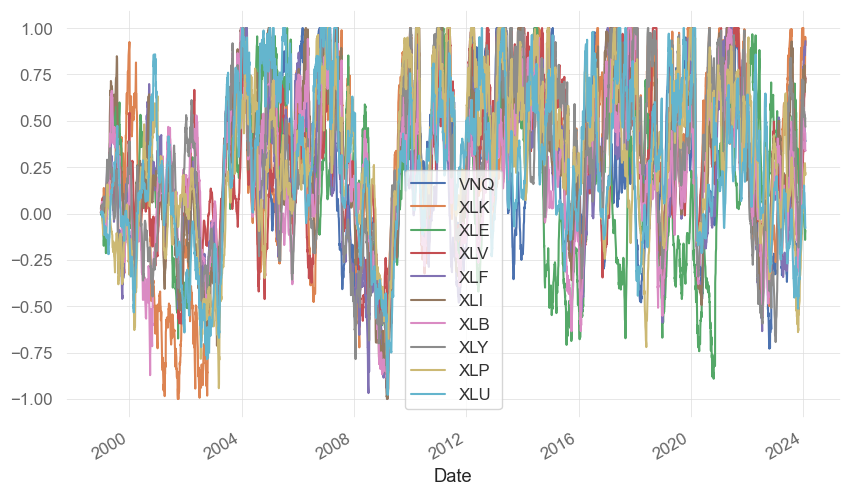

In [59]:
avg_ewmacs.plot();

In [60]:
#https://engineeredportfolio.com/2018/05/02/accelerating-dual-momentum-investing/
def dual_momentum(price, lengths=[22, 22*3, 22*6]):
    vol_lookback = 25
    stdev_returns=price.diff().ewm(span=vol_lookback).std()
    returns = pd.DataFrame()
    for l in lengths:
        returns[l] = price.pct_change(l)/stdev_returns 
    returns = returns.sum(axis=1)/len(lengths)
    return returns

In [61]:
avg_mom = pd.DataFrame(index = full_df.index)
avg_mom = pd.DataFrame([dual_momentum(full_df[symbol]) for symbol in symbols], index=symbols).T
avg_mom = avg_mom.resample('D').last().ffill().fillna(method='ffill').shift(1)
avg_mom_full = avg_mom.copy()

In [62]:
#rebalancing_dates = pd.date_range(start=datetime.date(2005,1,1), end = datetime.datetime.today(), freq='M')
#rebalancing_dates

In [63]:
dates_df = pd.DataFrame(index = full_df.index)
dates_df['Date'] = dates_df.index
reb_dates = list(dates_df.groupby([dates_df['Date'].dt.year, dates_df['Date'].dt.month], as_index=False).last()['Date'].values)
rebalancing_dates = [pd.to_datetime(dt).date() for dt in reb_dates if dt >= pd.to_datetime('2005-01-01')]

In [64]:
def return_weights(input_dfs, min_val=0, num_assets=5):
    
    weights = pd.DataFrame()
    for i, date in enumerate(rebalancing_dates):
        
        date_weights = {}
        date_weights['Date'] = date
        long = []
        
        for input_df in input_dfs:
            sorted_values = input_df[:date].iloc[-1].sort_values(ascending=False)
            
            if not len(sorted_values[sorted_values > min_val]):
                print(f'{date}: No positive: all in cash')
            else:
                long.extend(list(sorted_values[sorted_values > min_val].index[:num_assets]))
                print(print(f'{date}: {len(long)}'))
                
                """
                tt = sorted_values[sorted_values > min_val][:num_assets]
                tt/=tt.sum()
                date_weights.update(tt.to_dict())
                """
                
        long = list(set(long))
    
        for ticker in long:
            date_weights[ticker] = 1/len(long)
        for ticker in input_df.columns:
            if ticker not in long:
                date_weights[ticker] = 0
                
        weights = pd.concat([weights, pd.DataFrame.from_dict(date_weights, orient='index').T], axis=0)
    weights.set_index('Date', inplace=True)
    weights = weights[full_df.columns]
    weights.index = pd.to_datetime(weights.index)
    return weights

In [65]:
num_assets=5
dfw_ewmac = return_weights([avg_ewmacs], min_val=0., num_assets=num_assets)
dfw_mom = return_weights([avg_mom], min_val=0, num_assets=num_assets)
#dfw_comb = return_weights([avg_ewmacs, avg_mom])

2005-01-31: 5
None
2005-02-28: 5
None
2005-03-31: 5
None
2005-04-29: 5
None
2005-05-31: 5
None
2005-06-30: 5
None
2005-07-29: 5
None
2005-08-31: 5
None
2005-09-30: 5
None
2005-10-31: 5
None
2005-11-30: 5
None
2005-12-30: 5
None
2006-01-31: 5
None
2006-02-28: 5
None
2006-03-31: 5
None
2006-04-28: 5
None
2006-05-31: 5
None
2006-06-30: 5
None
2006-07-31: 5
None
2006-08-31: 5
None
2006-09-29: 5
None
2006-10-31: 5
None
2006-11-30: 5
None
2006-12-29: 5
None
2007-01-31: 5
None
2007-02-28: 5
None
2007-03-30: 5
None
2007-04-30: 5
None
2007-05-31: 5
None
2007-06-29: 5
None
2007-07-31: 5
None
2007-08-31: 5
None
2007-09-28: 5
None
2007-10-31: 5
None
2007-11-30: 5
None
2007-12-31: 5
None
2008-01-31: 2
None
2008-02-29: 2
None
2008-03-31: 3
None
2008-04-30: 5
None
2008-05-30: 5
None
2008-06-30: 3
None
2008-07-31: No positive: all in cash
2008-08-29: 2
None
2008-09-30: 1
None
2008-10-31: No positive: all in cash
2008-11-28: No positive: all in cash
2008-12-31: No positive: all in cash
2009-01-30: No p

In [66]:
dfw_ewmac

,VNQ,XLK,XLE,XLV,XLF,XLI,XLB,XLY,XLP,XLU
Date,,,,,,,,,,
2005-01-31,0,0,0.2,0,0,0.2,0.2,0,0.2,0.2
2005-02-28,0,0,0.2,0,0,0.2,0.2,0,0.2,0.2
2005-03-31,0,0,0.2,0,0,0.2,0.2,0,0.2,0.2
2005-04-29,0.2,0,0.2,0.2,0,0,0,0,0.2,0.2
2005-05-31,0.2,0,0.2,0.2,0,0,0,0,0.2,0.2
...,...,...,...,...,...,...,...,...,...,...
2023-09-29,0,0.2,0.2,0,0.2,0.2,0,0.2,0,0
2023-10-31,0,0.5,0.5,0,0,0,0,0,0,0
2023-11-30,0,0.2,0,0,0.2,0.2,0.2,0.2,0,0


In [67]:
full_df['CASH'] = 100

In [68]:
def run_backtest(weights, aum):
    """
    
    """
    # Create a rebalancing schedule (monthly)
    rebalancing_dates = weights.index

    # Initialize portfolio value and track performance
    portfolio_value = [aum]  # Start with an initial investment equal to aum
    portfolio_weights = []
    dates = []
    reb_dates = []

    for i in range(1, len(full_df)):
        
        date = full_df.index[i]
        
        if date < rebalancing_dates[0]:
            continue
        
        if date == full_df.last_valid_index():    
            continue
        
        current_prices = full_df.loc[date:].iloc[0]  #double check, we shifted the momentum signal (and so the weights) so we should be able to trade on this close
        # Check if it's the end of the month (rebalancing date)
        if date in rebalancing_dates:
            reb_dates.append(date)
            # Get the current weights and prices at the rebalancing date
            current_weights = weights.loc[date].to_dict()
            total_investment = portfolio_value[-1]
            
            total_investment = total_investment - (len(weights.columns)/2) # 1$ transaction cost

            # Calculate the number of shares to hold for each asset based on target weights
            shares_to_hold = {asset: total_investment * weight / price
                              for asset, weight, price in zip(current_weights.keys(),
                                                              current_weights.values(),
                                                              current_prices.values)
                            }
            #print(shares_to_hold, current_prices)
            # Update the portfolio value with the total investment after rebalancing
            total_investment = sum(shares_to_hold[asset] * price
                                   for asset, price 
                                   in zip(current_prices.index, current_prices.values))
        
            portfolio_value.append(total_investment)
            portfolio_weights.append(current_weights)
            
        else:
            # Interpolate the portfolio value for the days between rebalancing dates            
            total_investment = sum(shares_to_hold[asset] * price
                                   for asset, price 
                                   in zip(current_prices.index, current_prices.values))
            
            portfolio_value.append(total_investment)
        #print(date, total_investment)
        dates.append(date)

    # Convert the results to a DataFrame
    results_df = pd.DataFrame({'Cumulative': portfolio_value[1:]}, index=dates)
    results_df['Returns'] = results_df['Cumulative'].pct_change()
    results_df.index = pd.to_datetime(results_df.index)
    return results_df, reb_dates


In [69]:
dfw_ewmac['CASH'] = 1 - dfw_ewmac.sum(axis=1)
dfw_mom['CASH'] = 1 - dfw_mom.sum(axis=1)
#dfw_comb['CASH'] = 1 - dfw_comb.sum(axis=1)

In [70]:
dfw_mom['2023':]

,VNQ,XLK,XLE,XLV,XLF,XLI,XLB,XLY,XLP,XLU,CASH
Date,,,,,,,,,,,
2023-01-31,0.2,0,0.2,0,0.2,0.2,0.2,0,0,0,0.0
2023-02-28,0,0,0,0,0.333333,0.333333,0.333333,0,0,0,0.0
2023-03-31,0,0.2,0.2,0,0,0.2,0.2,0,0.2,0,0.0
2023-04-28,0,0.2,0,0,0,0.2,0.2,0,0.2,0.2,0.0
2023-05-31,0,0.5,0,0,0,0,0,0.5,0,0,0.0
2023-06-30,0,0.2,0,0,0.2,0.2,0.2,0.2,0,0,0.0
2023-07-31,0,0.2,0,0,0.2,0.2,0.2,0.2,0,0,0.0
2023-08-31,0,0.2,0.2,0,0.2,0.2,0.2,0,0,0,0.0
2023-09-29,0,0.25,0.25,0,0.25,0,0,0.25,0,0,0.0


In [71]:
results_ewmac, _1 = run_backtest(dfw_ewmac, 10000)
results_mom, _2 = run_backtest(dfw_mom, 10000)
#results_comb, _3 = run_backtest(dfw_comb, 10000)

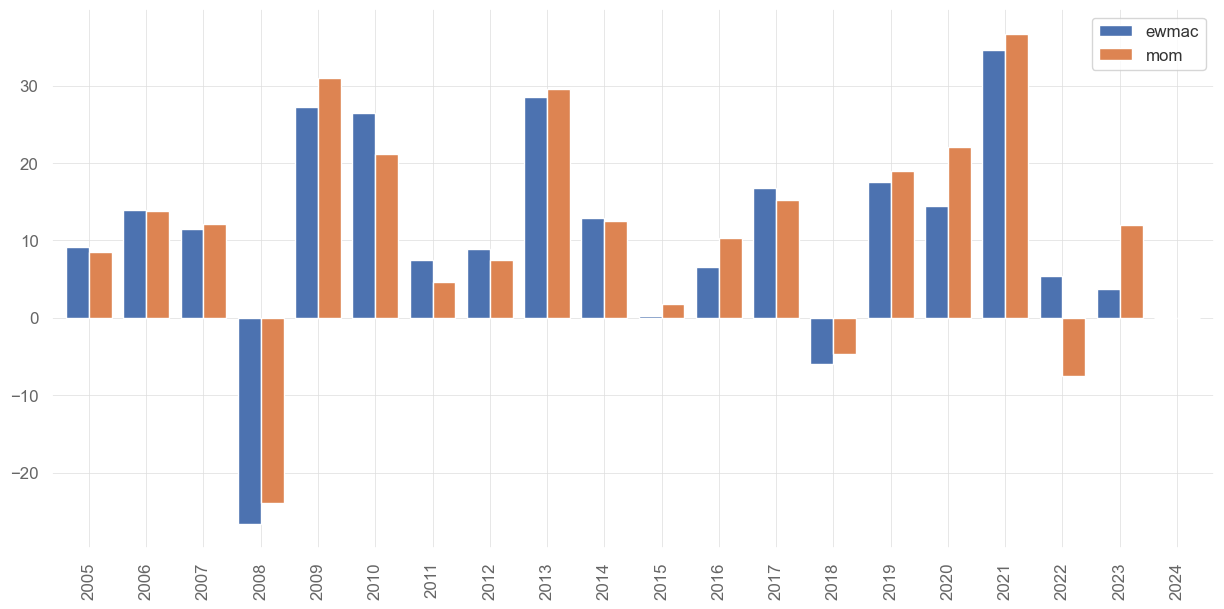

In [72]:
yearly_returns_ewmac = ((results_ewmac['Returns']).groupby([results_ewmac['Returns'].index.year]).sum()*100)
yearly_returns_mom = ((results_mom['Returns']).groupby([results_mom['Returns'].index.year]).sum()*100)
comb_returns = pd.concat([yearly_returns_ewmac, yearly_returns_mom], axis=1)
comb_returns.columns = ['ewmac', 'mom']
comb_returns.plot(kind='bar', width=0.8, figsize=(15,7));

In [73]:
import quantstats as qs

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2005-02-01   2005-02-01
End Period                 2024-01-26   2024-01-26
Risk-Free Rate             0.0%         0.0%
Time in Market             95.0%        96.0%

Cumulative Return          621.36%      558.75%
CAGR﹪                     7.45%        7.09%

Sharpe                     0.73         0.71
Prob. Sharpe Ratio         99.92%       99.88%
Smart Sharpe               0.66         0.64
Sortino                    1.03         0.98
Smart Sortino              0.93         0.89
Sortino/√2                 0.73         0.7
Smart Sortino/√2           0.66         0.63
Omega                      1.15         1.15

Max Drawdown               -31.68%      -34.32%
Longest DD Days            761          665
Volatility (ann.)          16.02%       15.88%
R^2                        0.83         0.83
Information Ratio          -0.0         -0.0
Calmar               

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2008-05-20,2008-10-27,2010-03-15,665,-34.316750,-30.828643
2,2020-02-18,2020-03-23,2020-09-01,197,-31.078755,-25.247002
3,2018-09-14,2018-12-24,2019-12-11,454,-17.593257,-15.262054
4,2015-07-21,2016-01-20,2017-02-10,571,-15.799244,-14.900333
5,2022-11-16,2023-03-15,2024-01-26,437,-15.433806,-14.395567


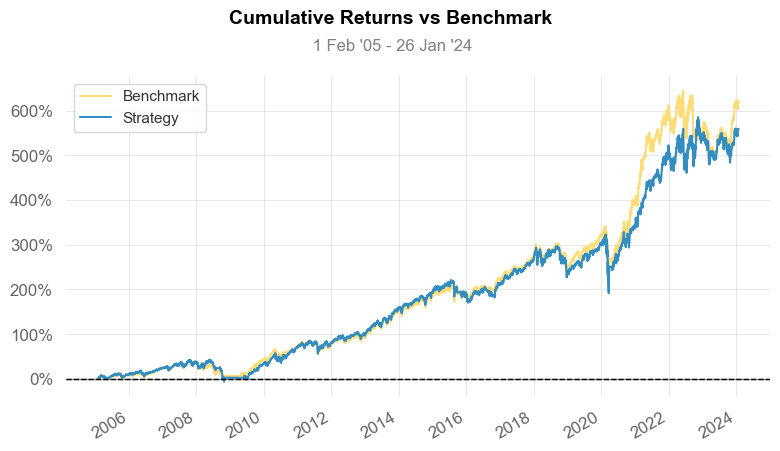

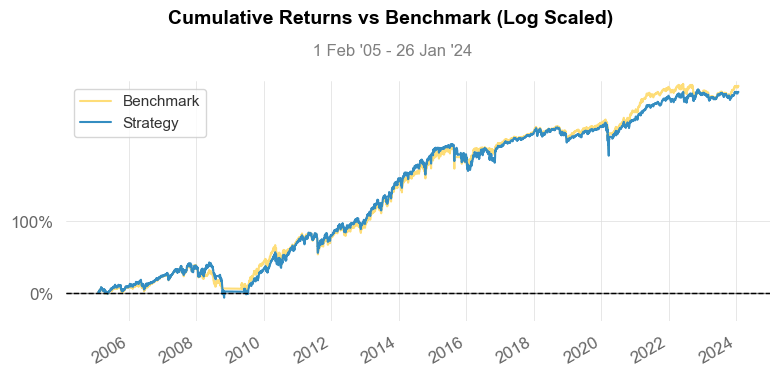

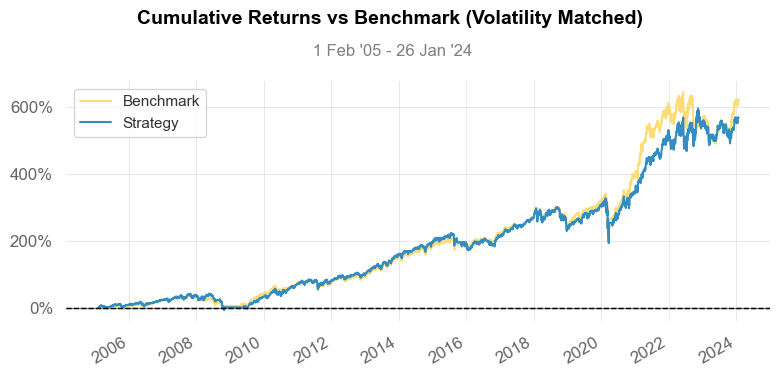

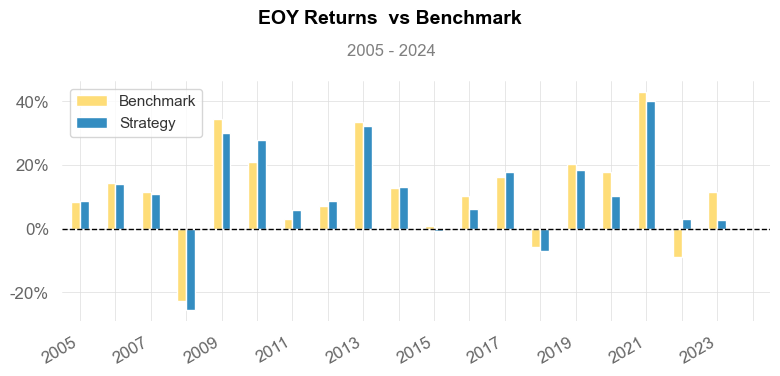

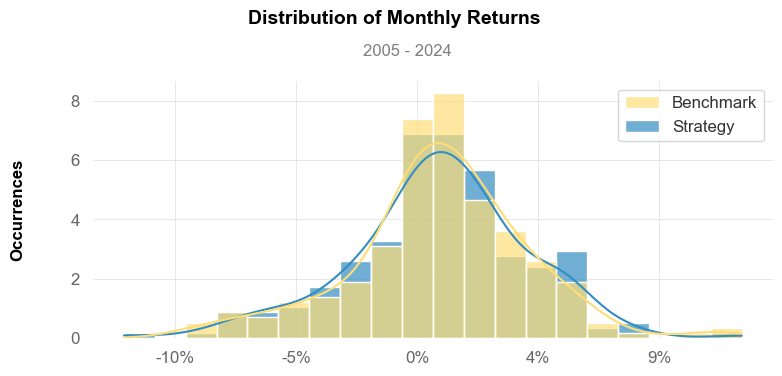

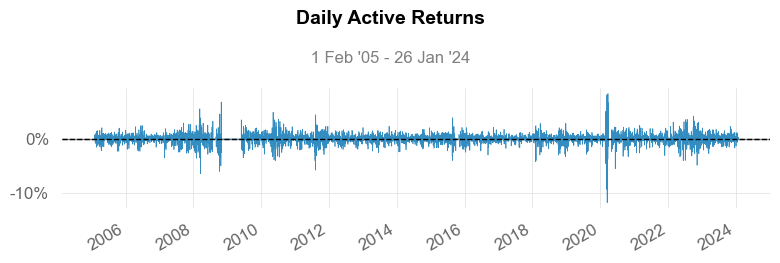

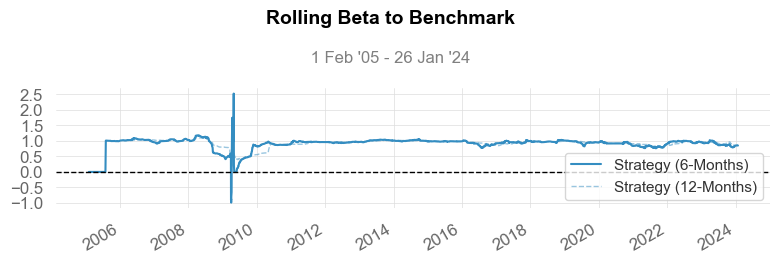

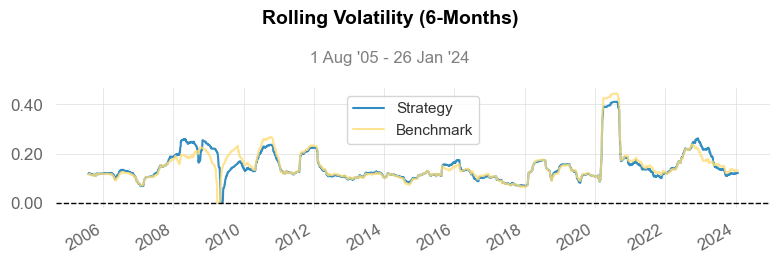

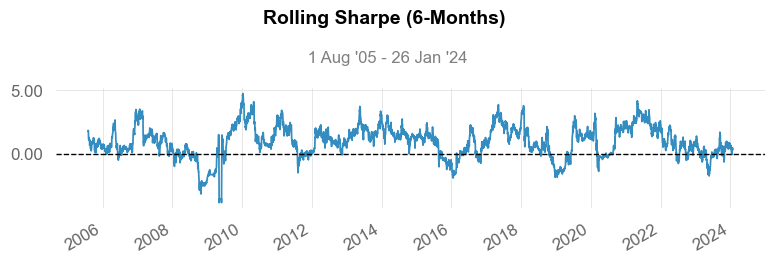

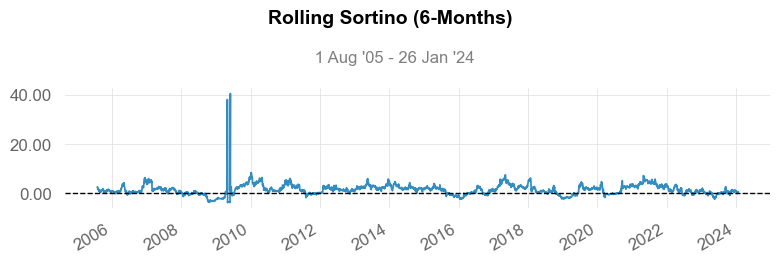

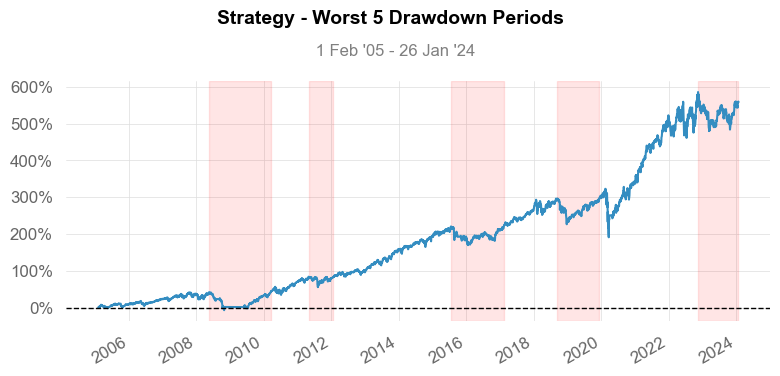

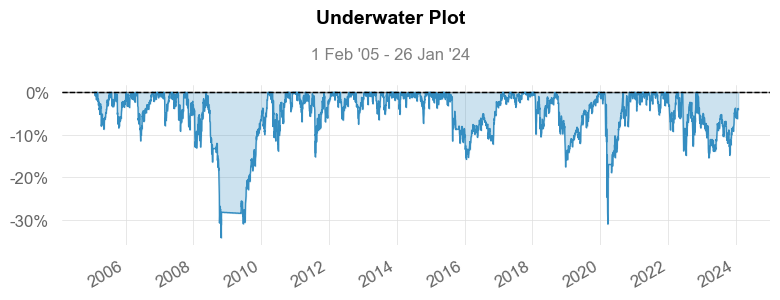

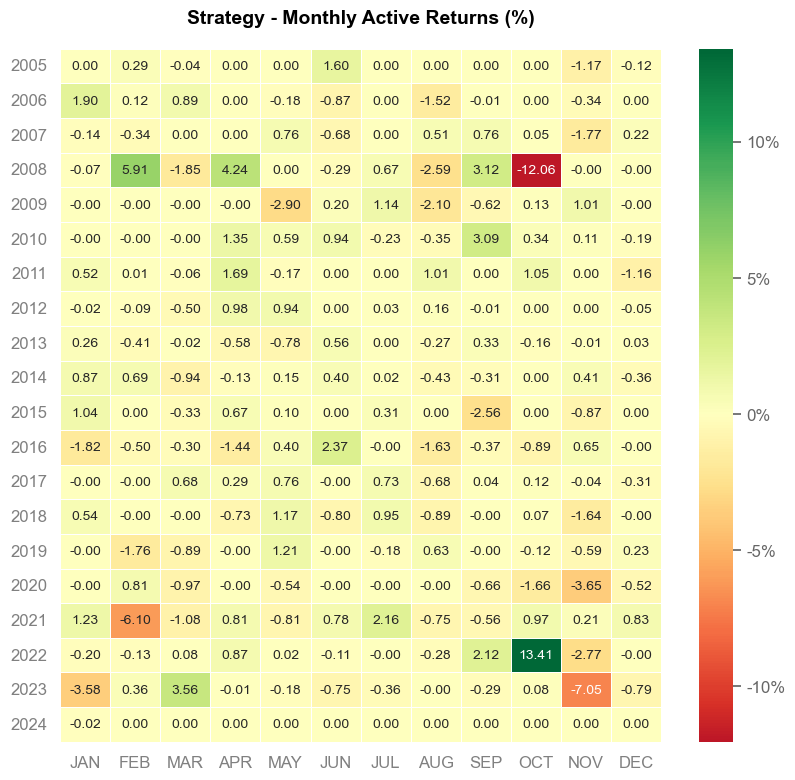

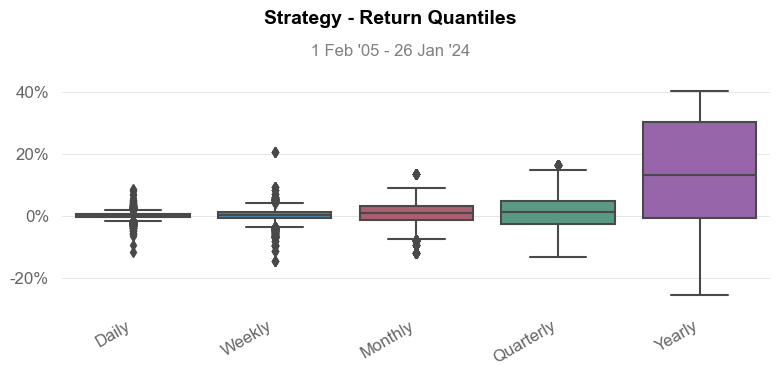

In [74]:
qs.reports.full(returns=results_ewmac['Cumulative'], 
                benchmark=results_mom['Cumulative'],
                output='report.html', 
                title='Sector Rotation Strategy')

In [75]:
dfw_ewmac['2022-09':]

,VNQ,XLK,XLE,XLV,XLF,XLI,XLB,XLY,XLP,XLU,CASH
Date,,,,,,,,,,,
2022-09-30,0,0,0.5,0,0,0,0,0,0,0.5,0.0
2022-10-31,0,0,1.0,0,0,0,0,0,0,0,0.0
2022-11-30,0,0,0.2,0.2,0.2,0.2,0,0,0.2,0,0.0
2022-12-30,0,0,0.2,0.2,0,0.2,0,0,0.2,0.2,0.0
2023-01-31,0,0,0.2,0.2,0.2,0.2,0.2,0,0,0,0.0
2023-02-28,0,0.2,0.2,0,0.2,0.2,0.2,0,0,0,0.0
2023-03-31,0,0.333333,0,0,0,0.333333,0,0,0.333333,0,0.0
2023-04-28,0,0.2,0.2,0.2,0,0.2,0,0,0.2,0,0.0
2023-05-31,0,0.25,0,0,0,0.25,0,0.25,0.25,0,0.0


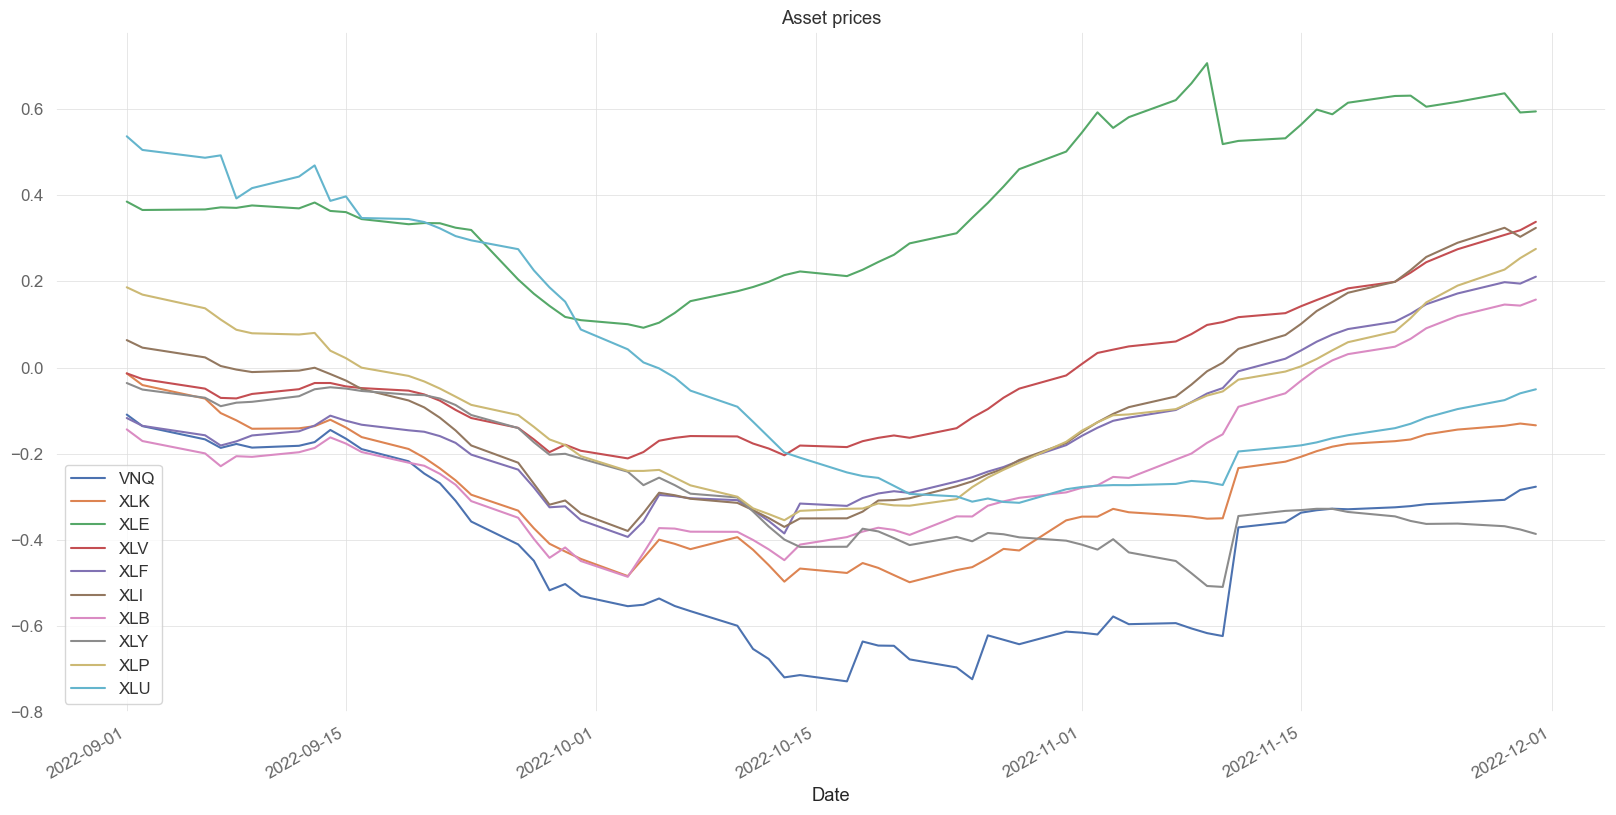

In [76]:
avg_ewmacs['2022-09':'2022-11'].plot(figsize=(20,10), grid=True, title='Asset prices');

<Axes: xlabel='Date'>

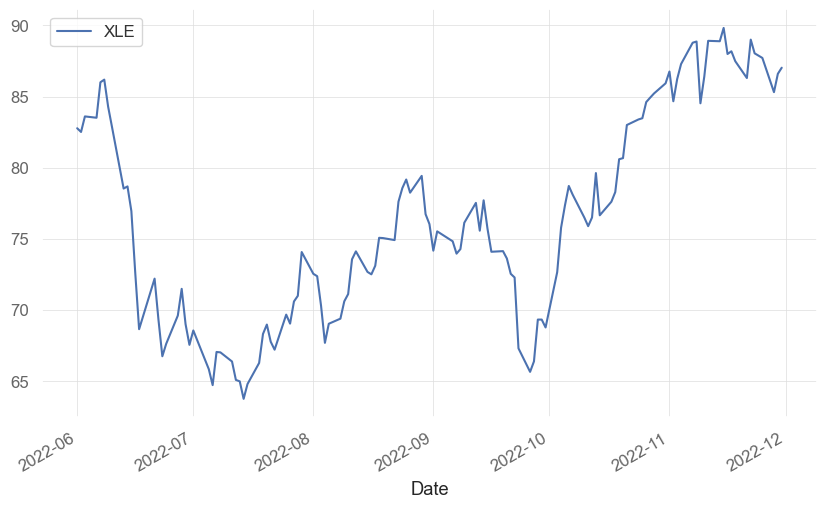

In [77]:
full_df[['XLE']]['2022-06':'2022-11'].plot()

<Axes: xlabel='Date'>

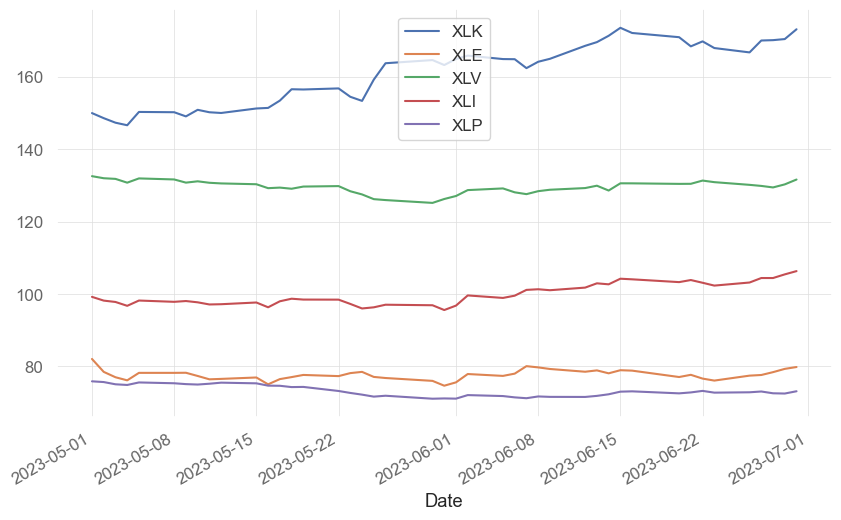

In [78]:
full_df[['XLK', 'XLE', 'XLV', 'XLI', 'XLP']]['2023-05':'2023-06'].plot()

In [79]:
results_ewmac['Returns']['2023-05']

2023-05-01    0.000132
2023-05-02   -0.013978
2023-05-03   -0.008009
2023-05-04   -0.007408
2023-05-05    0.016954
2023-05-08   -0.001878
2023-05-09   -0.003024
2023-05-10   -0.000190
2023-05-11   -0.004431
2023-05-12    0.000677
2023-05-15    0.002781
2023-05-16   -0.010547
2023-05-17    0.009953
2023-05-18    0.005643
2023-05-19    0.001929
2023-05-22   -0.003231
2023-05-23   -0.007177
2023-05-24   -0.005933
2023-05-25    0.001756
2023-05-26    0.007210
2023-05-30   -0.004474
2023-05-31   -0.000093
Name: Returns, dtype: float64

## Risk Overlay

In [80]:
from scipy.stats import t
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.optimize import Bounds

class RiskMeasures:
    
    def __init__(self, confidence_level):
        self._confidence_level = confidence_level
    
    def value_at_risk(self, returns):
        return returns.quantile(self._confidence_level)

    def gaussian_var(self, returns):
        z = norm.ppf(self._confidence_level)
        s = returns.skew()
        k = returns.kurtosis()
        z = (z +
                (z**2 - 1)*s/6 +
                (z**3 -3*z)*(k-3)/24 -
                (2*z**3 - 5*z)*(s**2)/36
            )
        return (returns.mean() + z*returns.std(ddof=0))
        
    def expected_shortfall(self, returns):
        returns = returns[returns!=0]
        var = self.value_at_risk(returns)
        return abs(returns[returns.lt(var)].mean())

In [81]:
def fun_rolling_cvar(rets):
    rm = RiskMeasures(confidence_level=0.05)
    risk_strategy = rm.expected_shortfall(returns=rets)
    return risk_strategy

In [82]:
bm_price = get_data(yf.Ticker('IVV'))
bm_price.index = bm_price.index.tz_localize(None)

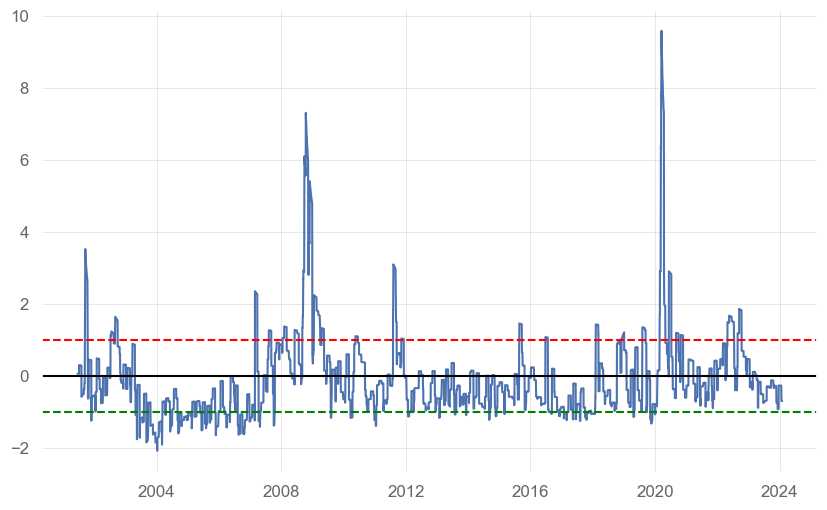

In [83]:
rolling_cvar = np.log(bm_price).diff().rolling(window=20).apply(fun_rolling_cvar)
#rolling_cvar = rolling_cvar.shift()
cvar_zscore = ((rolling_cvar - rolling_cvar.rolling(window=252*10, min_periods=252).mean())/rolling_cvar.rolling(window=252*10, min_periods=252).std())
plt.plot(cvar_zscore)
plt.axhline(0, color='black')
plt.axhline(1, color='red', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')


In [84]:
df_risk = pd.DataFrame(rolling_cvar.ewm(span=15).mean())
df_risk.columns = ['Risk']
df_risk['limit'] = df_risk['Risk'].rolling(window=250, min_periods=1).mean() + df_risk['Risk'].rolling(window=250, min_periods=1).std()
df_risk = df_risk.shift()
df_risk['breached'] = np.where(df_risk['Risk'] > df_risk['limit'], 1, 0)
df_risk['action'] = df_risk['breached'].diff()
df_risk = df_risk[dfw_mom.first_valid_index():] 

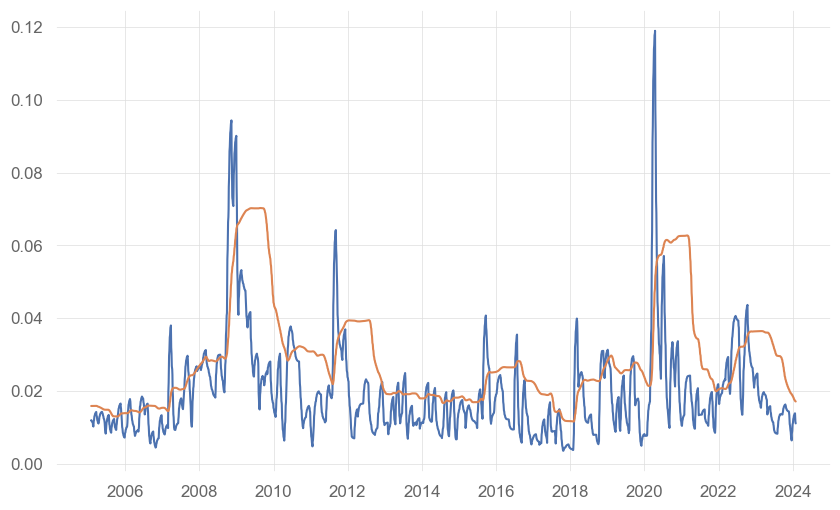

In [85]:
plt.plot(df_risk['Risk'])
plt.plot(df_risk['limit'])

In [86]:
df_risk[df_risk['action'] != 0]

,Risk,limit,breached,action
Date,,,,
2005-10-20,0.013026,0.013017,1,1.0
2005-11-25,0.013667,0.013867,0,-1.0
2006-01-27,0.014222,0.013935,1,1.0
2006-02-28,0.014458,0.014705,0,-1.0
2006-05-24,0.014602,0.014139,1,1.0
...,...,...,...,...
2022-04-12,0.021968,0.022053,0,-1.0
2022-04-27,0.022384,0.022335,1,1.0
2022-07-22,0.030451,0.031916,0,-1.0


In [87]:
dfw_risk = pd.DataFrame()
dfw_ewmac_clean = dfw_mom.copy()
del dfw_ewmac_clean['CASH']

for i, (index, row) in enumerate(full_df[dfw_ewmac_clean.first_valid_index():].iterrows()):
    if index > dfw_ewmac_clean.index[-1]:
        continue
    else:
        given_weights = dfw_ewmac_clean.loc[index:].iloc[0]
        if index in df_risk.index:
            if (df_risk.loc[index]['breached'] == 1) and (df_risk.loc[index]['action'] == 1):
                print('breached', index)
                given_weights = pd.DataFrame(index=[index], columns = dfw_ewmac_clean.columns).fillna(0).T
                #given_weights/=2
                dfw_risk = pd.concat([dfw_risk, pd.DataFrame(given_weights).T], axis=0)  
            elif (df_risk.loc[index]['breached'] == 0) and (df_risk.loc[index]['action'] == -1):
                print('reinvest', index)
                given_weights = pd.DataFrame(index= dfw_ewmac_clean.columns, data=given_weights.values, columns = [index])
                dfw_risk = pd.concat([dfw_risk, pd.DataFrame(given_weights).T], axis=0)  
            else:
                if index in dfw_ewmac_clean.index and (df_risk.loc[index]['breached'] == 0):
                    dfw_risk = pd.concat([dfw_risk, pd.DataFrame(given_weights).T], axis=0) 
        

breached 2005-10-20 00:00:00
reinvest 2005-11-25 00:00:00
breached 2006-01-27 00:00:00
reinvest 2006-02-28 00:00:00
breached 2006-05-24 00:00:00
reinvest 2006-07-07 00:00:00
breached 2006-07-25 00:00:00
reinvest 2006-08-11 00:00:00
breached 2007-03-01 00:00:00
reinvest 2007-04-13 00:00:00
breached 2007-08-07 00:00:00
reinvest 2007-09-20 00:00:00
breached 2007-11-16 00:00:00
reinvest 2007-12-10 00:00:00
breached 2008-02-06 00:00:00
reinvest 2008-03-10 00:00:00
breached 2008-06-25 00:00:00
reinvest 2008-07-28 00:00:00
breached 2008-09-16 00:00:00
reinvest 2009-01-06 00:00:00
breached 2010-05-17 00:00:00
reinvest 2010-07-29 00:00:00
breached 2011-08-05 00:00:00
reinvest 2011-10-05 00:00:00
breached 2012-12-04 00:00:00
reinvest 2012-12-07 00:00:00
breached 2013-04-29 00:00:00
reinvest 2013-05-16 00:00:00
breached 2013-06-27 00:00:00
reinvest 2013-07-25 00:00:00
breached 2014-02-04 00:00:00
reinvest 2014-03-06 00:00:00
breached 2014-04-25 00:00:00
reinvest 2014-05-13 00:00:00
breached 2014-

In [88]:
dfw_risk

,VNQ,XLK,XLE,XLV,XLF,XLI,XLB,XLY,XLP,XLU
2005-01-31,0,0,0.2,0,0.2,0,0.2,0,0.2,0.2
2005-02-28,0,0,0.2,0.2,0,0,0.2,0,0.2,0.2
2005-03-31,0,0,0.2,0,0,0.2,0.2,0,0.2,0.2
2005-04-29,0.2,0,0.2,0.2,0,0,0,0,0.2,0.2
2005-05-31,0.2,0.2,0,0.2,0,0,0,0,0.2,0.2
...,...,...,...,...,...,...,...,...,...,...
2023-09-29,0,0.25,0.25,0,0.25,0,0,0.25,0,0
2023-10-31,0,1.0,0,0,0,0,0,0,0,0
2023-11-30,0.2,0.2,0,0,0.2,0.2,0.2,0,0,0
2023-12-29,0.2,0.2,0,0,0.2,0.2,0.2,0,0,0


In [89]:
dfw_risk.sort_index(inplace=True)
dfw_risk= dfw_risk[~dfw_risk.index.duplicated(keep='last')]
#dfw_risk.tail(30)

In [90]:
dfw_risk['CASH'] = 1 - dfw_risk.sum(axis=1)

In [91]:
dfw_risk.index

DatetimeIndex(['2005-01-31', '2005-02-28', '2005-03-31', '2005-04-29',
               '2005-05-31', '2005-06-30', '2005-07-29', '2005-08-31',
               '2005-09-30', '2005-10-20',
               ...
               '2023-04-28', '2023-05-31', '2023-06-30', '2023-07-31',
               '2023-08-31', '2023-09-29', '2023-10-31', '2023-11-30',
               '2023-12-29', '2024-01-29'],
              dtype='datetime64[ns]', length=250, freq=None)

In [92]:
results_risk, _ = run_backtest(dfw_risk, 10000)

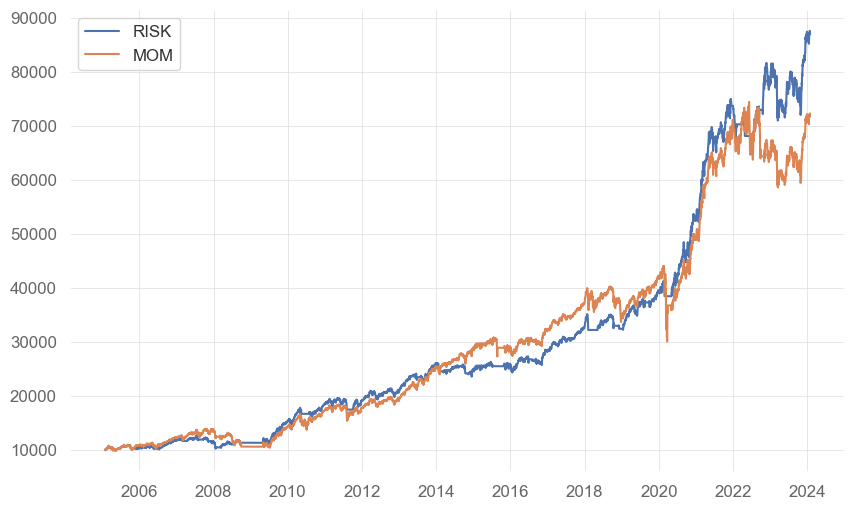

In [97]:
plt.plot(results_risk['Cumulative'], label = 'RISK')
plt.plot(results_mom['Cumulative'], label='MOM')
plt.legend()

In [98]:
qs.reports.metrics(returns=results_risk['Returns'], benchmark=results_mom['Returns'])

                    Benchmark    Strategy
------------------  -----------  ----------
Start Period        2005-02-01   2005-02-01
End Period          2024-01-26   2024-01-26
Risk-Free Rate      0.0%         0.0%
Time in Market      95.0%        81.0%

Cumulative Return   615.18%      766.37%
CAGR﹪              7.41%        8.16%

Sharpe              0.73         1.01
Prob. Sharpe Ratio  99.91%       100.0%
Sortino             1.02         1.45
Sortino/√2          0.72         1.03
Omega               1.22         1.22

Max Drawdown        -31.68%      -19.27%
Longest DD Days     761          743

Gain/Pain Ratio     0.15         0.22
Gain/Pain (1M)      1.08         1.43

Payoff Ratio        1.06         1.09
Profit Factor       1.15         1.22
Common Sense Ratio  1.06         1.25
CPC Index           0.64         0.7
Tail Ratio          0.92         1.02
Outlier Win Ratio   3.71         5.46
Outlier Loss Ratio  3.86         4.58

MTD                 -0.06%       -0.06%
3M           

                           Strategy
-------------------------  ----------
Start Period               2005-01-31
End Period                 2024-01-26
Risk-Free Rate             0.0%
Time in Market             81.0%

Cumulative Return          773.86%
CAGR﹪                     8.2%

Sharpe                     1.02
Prob. Sharpe Ratio         100.0%
Smart Sharpe               0.98
Sortino                    1.46
Smart Sortino              1.4
Sortino/√2                 1.03
Smart Sortino/√2           0.99
Omega                      1.22

Max Drawdown               -19.27%
Longest DD Days            743
Volatility (ann.)          11.93%
Calmar                     0.43
Skew                       -0.32
Kurtosis                   4.69

Expected Daily %           0.05%
Expected Monthly %         0.95%
Expected Yearly %          11.45%
Kelly Criterion            9.58%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.19%
Expected Shortfall (cVaR)  -1.19%

Max Consecutive Wins       

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2007-07-20,2008-01-22,2009-07-31,743,-19.266166,-17.498617
2,2022-11-28,2023-03-17,2023-11-17,355,-13.072721,-12.368943
3,2011-05-20,2011-10-05,2012-01-24,250,-10.862804,-10.806819
4,2013-12-27,2014-12-16,2015-06-17,538,-9.655598,-7.980459
5,2021-12-13,2022-01-26,2022-10-21,313,-9.554880,-9.114422


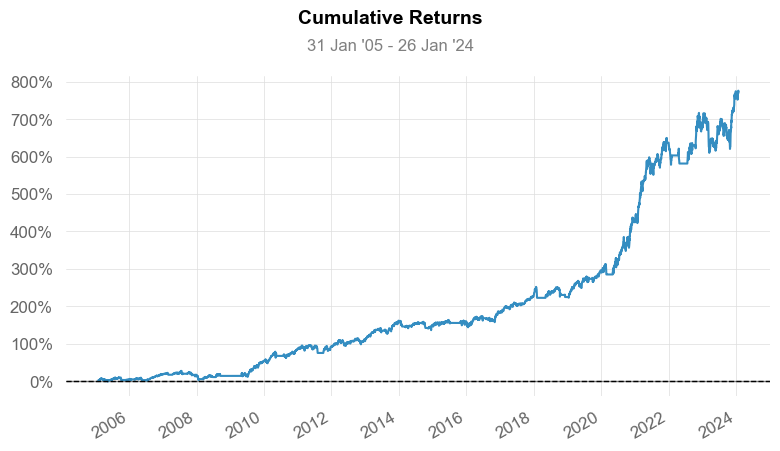

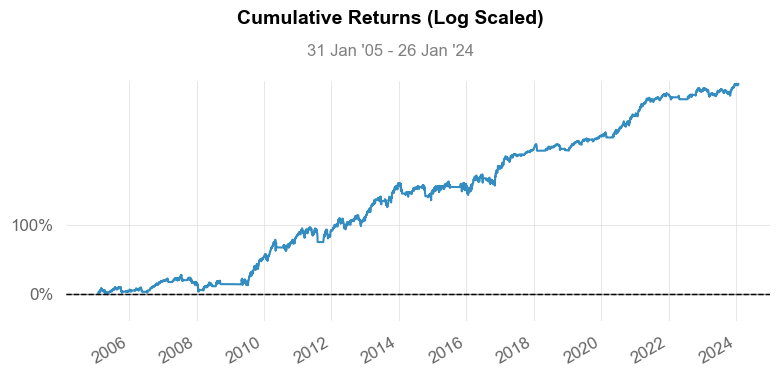

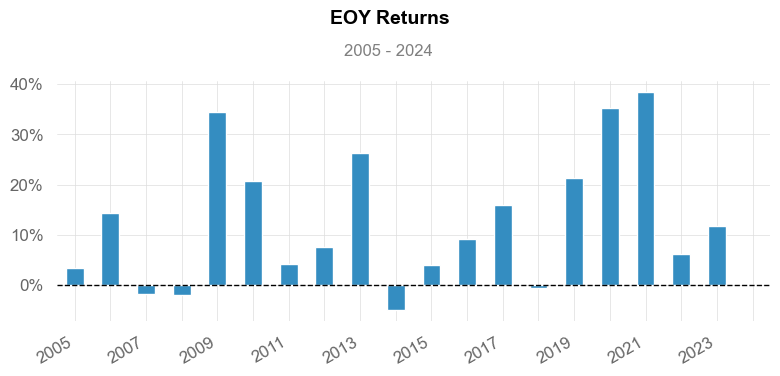

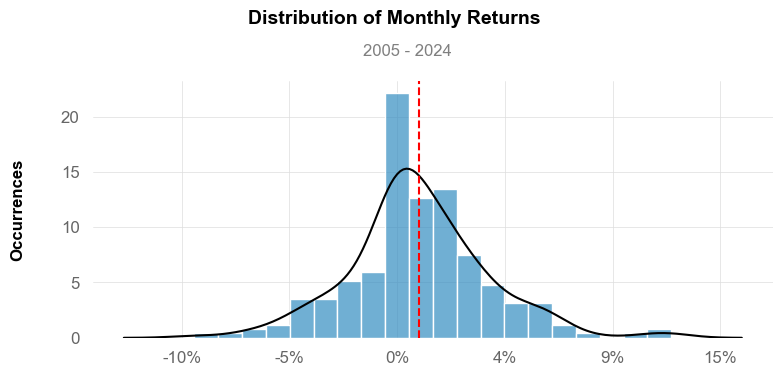

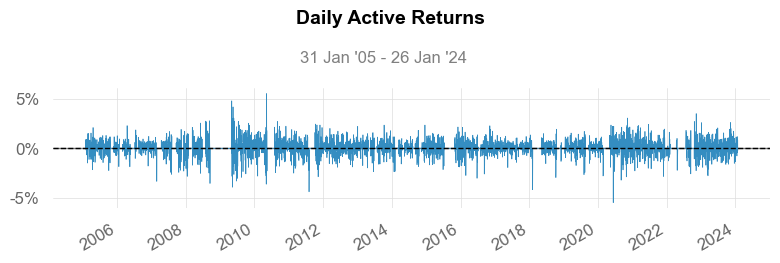

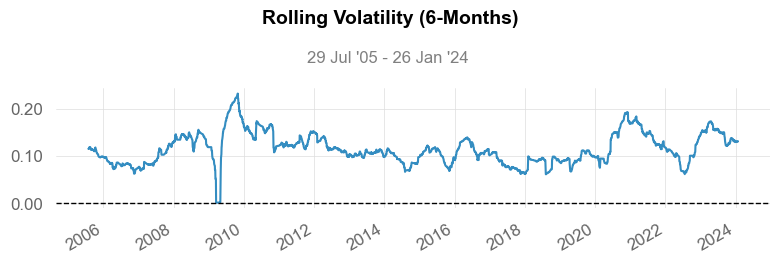

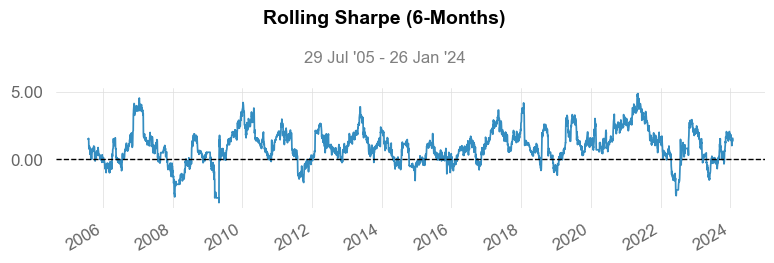

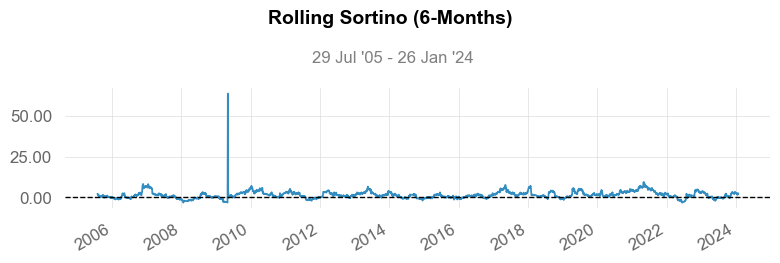

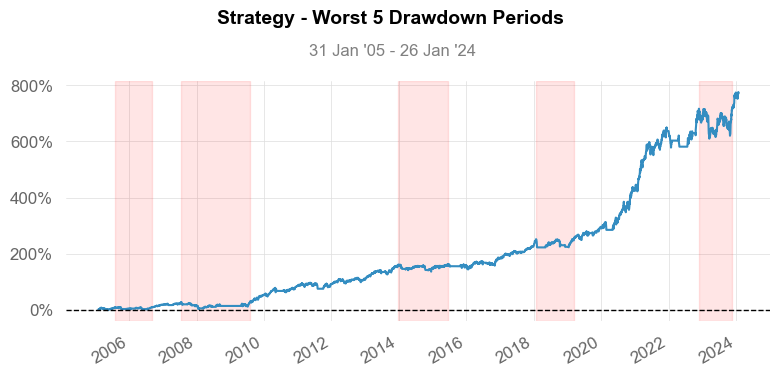

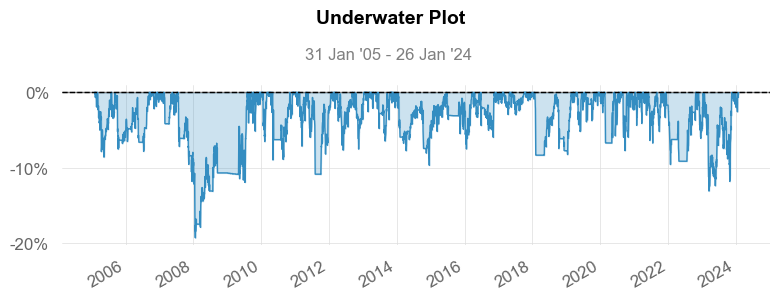

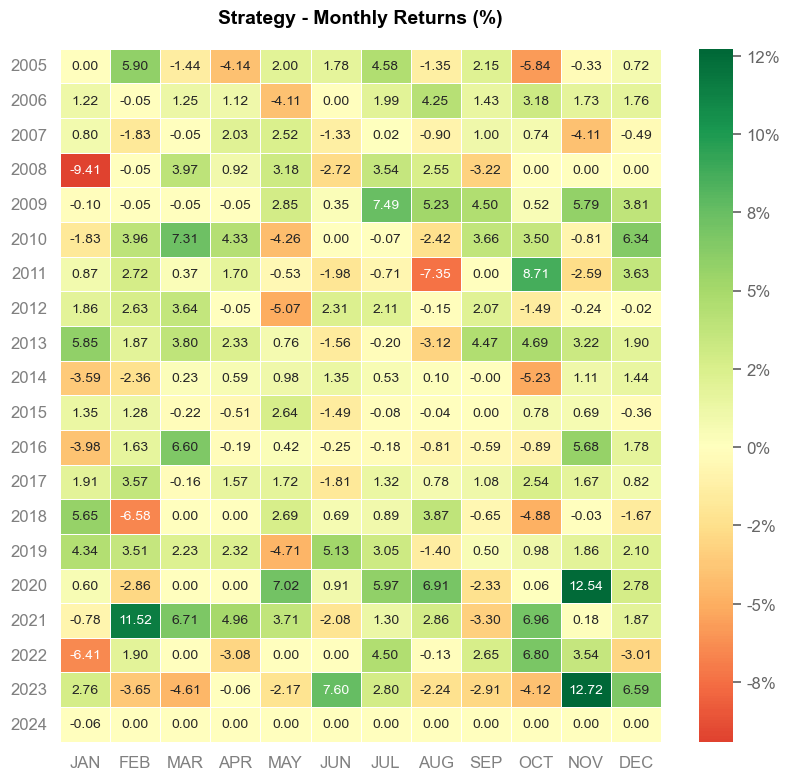

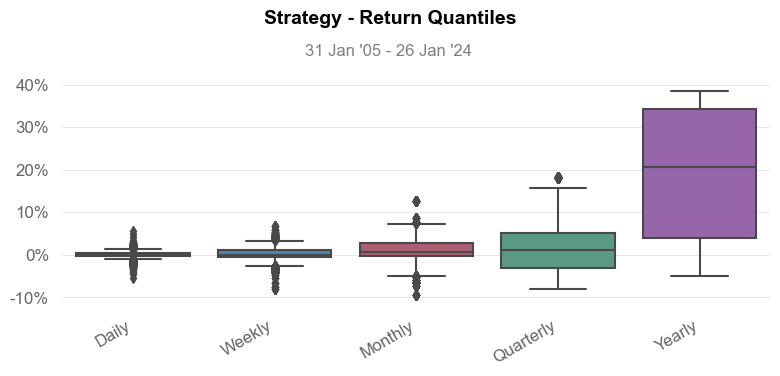

In [95]:
qs.reports.full(returns=results_risk['Cumulative'], 
                output='report.html', 
                title='Volatility Targeted Strategy')

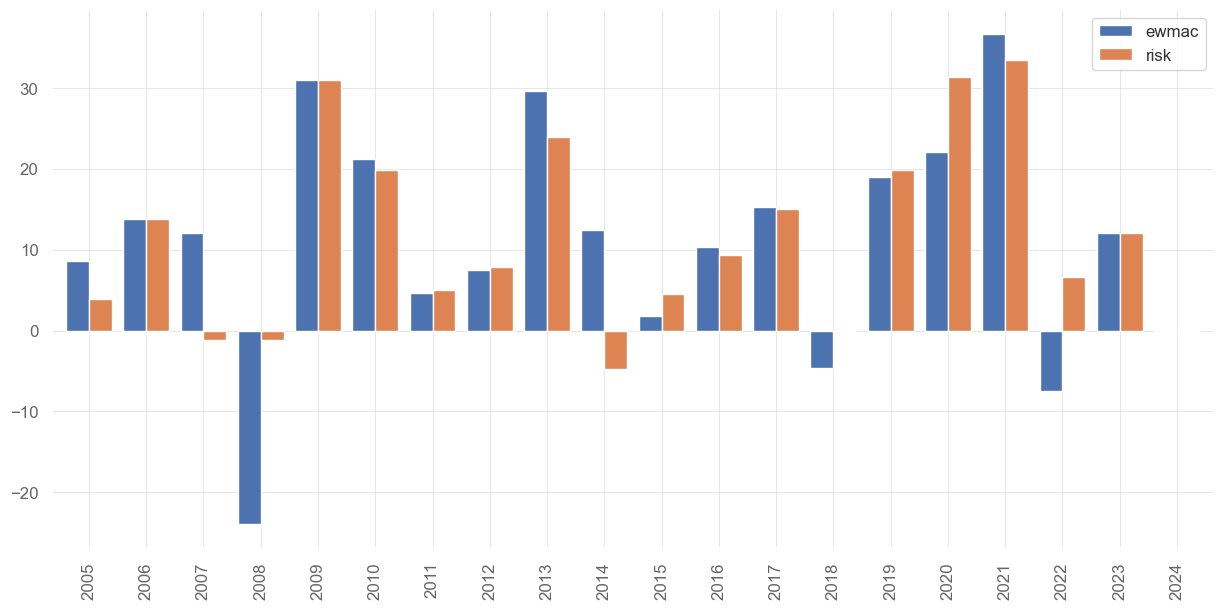

In [99]:
yearly_returns_ewmac = ((results_mom['Returns']).groupby([results_mom['Returns'].index.year]).sum()*100)
yearly_returns_risk = ((results_risk['Returns']).groupby([results_risk['Returns'].index.year]).sum()*100)
comb_returns = pd.concat([yearly_returns_ewmac, yearly_returns_risk], axis=1)
comb_returns.columns = ['ewmac', 'risk']
comb_returns.plot(kind='bar', width=0.8, figsize=(15,7));